In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set()


class Extractor(object):
    def __init__(self, path):
        with open(path, "r") as f:
            lines = f.readlines()
        self.epochlines = {}
        for mode in ["train", "test"]:
            key = "({}) Epoch".format(mode)
            self.epochlines[mode] = [line for line in lines if key in line]
        self.iterlines = {}
        for mode in ["train", "test"]:
            key = "({}) Iter".format(mode)
            self.iterlines[mode] = [line for line in lines if key in line]
        # print(self.epochlines['train'][0])
        # print(self.iterlines['train'][0])

    def __call__(self, mode, key, epoch=True):
        if epoch:
            lines = self.epochlines[mode]
        else:
            lines = self.iterlines[mode]
        key = "\'{}\'".format(key)
        lines = [re.split('[{}]', line)[1].split(', ') for line in lines]
        lines = [[item for item in line if key in item] for line in lines]
        lines = [float(line[0].split()[1]) for line in lines]
        return np.array(lines)


def get_b_t(data1, data2):
    b = min(data1.min(), data2.min())
    t = max(data1.max(), data2.max())
    return b, t


def show_hist(logfile):
    _s = 5
    _iter_per_batch = 32
    _n = 3

    ext = Extractor(logfile)
    plt.figure(figsize=(8,_n*2))
    plt.suptitle(logfile, x=0.5, y=0.92)

    data1 = ext("train", "x_loss")
    data2 = ext("test", "x_loss")
    plt.subplot(_n,1,1)
    plt.title("x_loss")
    b, t = get_b_t(data1[_s:], data2[_s:])
    plt.ylim([b-(t-b)*0.1, t+(t-b)*0.1])
    sns.lineplot(data=data1)
    sns.lineplot(data=data2)

    data1 = ext("train", "s_loss")
    data2 = ext("test", "s_loss")
    plt.subplot(_n,1,2)
    plt.title("s_loss")
    b, t = get_b_t(data1[_s:], data2[_s:])
    plt.ylim([b-(t-b)*0.1, t+(t-b)*0.1])
    sns.lineplot(data=data1)
    sns.lineplot(data=data2)

#     data1 = ext("train", "s_snd_loss")
#     data2 = ext("test", "s_snd_loss")
#     plt.subplot(_n,1,3)
#     plt.title("s_snd_loss")
#     b, t = get_b_t(data1[10:], data2[10:])
#     plt.ylim([b-(t-b)*0.1, t+(t-b)*0.1])
#     sns.lineplot(data=data1)
#     sns.lineplot(data=data2)

#     data1 = ext("train", "s_over_loss")
#     data2 = ext("test", "s_over_loss")
#     plt.subplot(_n,1,4)
#     plt.title("s_over_loss")
#     b, t = get_b_t(data1[10:], data2[10:])
#     plt.ylim([b-(t-b)*0.1, t+(t-b)*0.1])
#     sns.lineplot(data=data1)
#     sns.lineplot(data=data2)

    data1 = ext("train", "g_grad_norm", epoch=False)
    plt.subplot(_n,1,3)
    b, t = get_b_t(data1[_s*_iter_per_batch:], data1[_s*_iter_per_batch:])
    plt.title("g_grad_norm")
    plt.ylim([b-(t-b)*0.1, t+(t-b)*0.1])
    sns.lineplot(data=data1)
    plt.axhline(y=1.2e+5, xmin=0, xmax=len(data1), c="k", linestyle=":")

    plt.show()

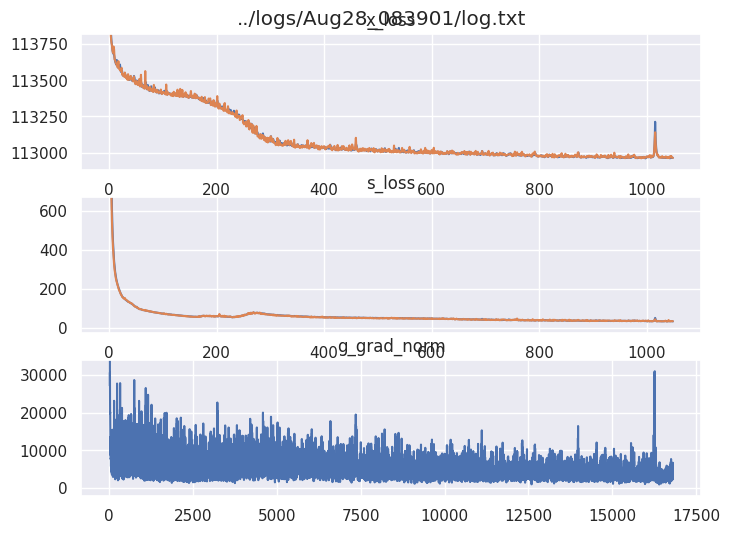

In [15]:
show_hist("../logs/Aug28_083901/log.txt")

In [ ]:
import os
import logzero
from config import get_args
from utils import set_seed
from model import SSM
from data_looper import MyDataLooper


args = get_args(jupyter=True, args="\
                --data_dir ./data/v3/ \
                --no_motion \
                --B 64 \
                --B_val 4 \
                --T_val 300 \
                --iters_to_accumulate 1 \
                --device 2 \
                --timestamp Jul10_201549 \
                --resume_epoch 100")

set_seed(args.seed)
model = SSM(args)

train_looper = MyDataLooper(model, args, "train")
test_looper = MyDataLooper(model, args, "test")

model.load(args.resume_epoch)

train_looper.write(epoch=9999)
test_looper.write(epoch=9999)

In [ ]:
import os
from config import get_args
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skvideo.io import vread
from tqdm import tqdm
from model import SSM
from utils import make_gif
# sns.reset_orig()


args = get_args(args="\
                --device 0 \
                --timestamp Jul10_201549 \
                --resume_epoch 100".split())
model = SSM(args)
model.load(args.resume_epoch)

data_dir = "./data/v3/"
vid = vread(os.path.join(data_dir, "test/video/frames.gif")).astype(np.uint8)
viw = np.load(os.path.join(data_dir, "test/view/views.npy")).astype(np.float32)[:, 3:]
# mot = np.load(os.path.join(data_dir, "test/motion/motions.npy")).astype(np.float32)

# bug of moviepy?
if np.sum(vid[-2] - vid[-1]) == 0:
    vid = vid[:-1]

viw_mean = np.load(os.path.join(data_dir, "param/viw_mean.npy"))
viw_std = np.load(os.path.join(data_dir, "param/viw_std.npy"))
viw = ((viw - viw_mean) / viw_std)

# print(vid.shape, viw.shape, mot.shape)
print(vid.shape, viw.shape)

In [ ]:
T = 300

for i in range(4):
    frames = []
    x_t = model.step(x_0=vid[T*i])

    for t in tqdm(range(T)):
        x_t = model.step(v_t=viw[T*i+t])
        x_t = cv2.putText(x_t.copy(), "{:04} / {}".format(t+1, T), 
                            (5, 8), cv2.FONT_HERSHEY_PLAIN, 
                            0.5, (0, 0, 0), 1, cv2.LINE_AA)
        frames.append(x_t)

    make_gif(vid[T*i:T*(i+1)], "true{:02}.gif".format(i))
    make_gif(frames, "pred{:02}.gif".format(i))